In [2]:
import xarray as xr
import numpy  as np
import pandas as pd
import proplot as pplt
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import copy # 用字典进行深拷贝

# 进行时间序列的PDF分布的绘制
2021.07.15

需要先计算四个区域的平均的时间序列，将AM和JJA拆分开来，之后计算AM JJA各自的经验分布函数，并绘图

2021.08.17

修改为空间pattern，并且使用在更大范围上

# 读取数据计算时间平均

-   计算am jja两个时间段

In [3]:
# 提取AM & JJA的降水的时间序列
# get partial mask_res collect into a dict
partial_list = ["NE", "NC", "YZ", "SC",'SW','NWC']
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m"
file_ref= "ydaymean_mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
file_vr = "ydaymean_mask_mean_t2m_98-17_VR.nc"
file_rcm = "ydaymean_mask_mean_t2m_98-17_RCM.nc"

partial_mean = {} # partial mask_res

for iregion in partial_list:
    partial_mean[iregion] = {}
    path_in_partial = path_in + "/" + iregion + "/ydaymean" # refine path
    print(path_in_partial)

    # obs
    partial_mean[iregion]['obs'] = {}
    xr_obs = xr.open_dataset(path_in_partial + "/" + file_ref)['tm']
    partial_mean[iregion]['obs']['am'] = xr_obs.sel(time = xr_obs.time.dt.month.isin([4,5])).mean(['time'])
    partial_mean[iregion]['obs']['jja'] = xr_obs.sel(time = xr_obs.time.dt.month.isin([6,7,8])).mean(['time'])

    # vr
    partial_mean[iregion]['vr'] = {}
    xr_vr = xr.open_dataset(path_in_partial + "/" + file_vr)['t2m']
    partial_mean[iregion]['vr']['am'] = xr_vr.sel(Time = xr_vr.Time.dt.month.isin([4,5])).mean(['Time']) - 273.15
    partial_mean[iregion]['vr']['jja'] = xr_vr.sel(Time = xr_vr.Time.dt.month.isin([6,7,8])).mean(['Time']) - 273.15

    # rcm
    partial_mean[iregion]['rcm'] = {}
    xr_rcm = xr.open_dataset(path_in_partial + "/" + file_rcm)['t2m']
    partial_mean[iregion]['rcm']['am'] = xr_rcm.sel(Time = xr_rcm.Time.dt.month.isin([4,5])).mean(['Time']) - 273.15
    partial_mean[iregion]['rcm']['jja'] = xr_rcm.sel(Time = xr_rcm.Time.dt.month.isin([6,7,8])).mean(['Time']) - 273.15

/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m/NE/ydaymean
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m/NC/ydaymean
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m/YZ/ydaymean
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m/SC/ydaymean
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m/SW/ydaymean
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_t2m/NWC/ydaymean


-   计算逐个月份

In [ ]:
# 提取各月份降水的时间序列
# get partial mask_res collect into a dict
partial_list = ["NE", "NC", "YZ", "SW"]
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/partial_t2m"
file_ref= "mask_sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
file_vr = "mask_mean_t2m_98-17_VR.nc"
file_rcm = "mask_mean_t2m_98-17_RCM.nc"

partial_mean = {} # partial mask_res

for iregion in partial_list:
    partial_mean[iregion] = {}
    path_in_partial = path_in + "/" + iregion + "/mask_res" # refine path
    print(path_in_partial)

    # obs
    partial_mean[iregion]['obs'] = {}
    xr_obs = xr.open_dataset(path_in_partial + "/" + file_ref)['tm']
    for imonth in [4,5,6,7,8]:
        partial_mean[iregion]['obs'][imonth] = xr_obs.sel(time = xr_obs.time.dt.month.isin(imonth)).mean(['lat','lon'])

    # vr
    partial_mean[iregion]['vr'] = {}
    xr_vr = xr.open_dataset(path_in_partial + "/" + file_vr)['t2m']
    for imonth in [4,5,6,7,8]:
        partial_mean[iregion]['vr'][imonth] = xr_vr.sel(Time = xr_vr.Time.dt.month.isin(imonth)).mean(['latitude','longitude']) - 273.15

    # rcm
    partial_mean[iregion]['rcm'] = {}
    xr_rcm = xr.open_dataset(path_in_partial + "/" + file_rcm)['t2m']
    for imonth in [4,5,6,7,8]:
        partial_mean[iregion]['rcm'][imonth] = xr_rcm.sel(Time = xr_rcm.Time.dt.month.isin(imonth)).mean(['latitude','longitude']) - 273.15

## 核密度估计

In [14]:
# 进行核密度估计
var_hist   = copy.deepcopy(partial_mean) # 存放直方图
var_kernel = copy.deepcopy(partial_mean) # 存放核密度估计结果
var_bins   = copy.deepcopy(partial_mean) # 存放x轴 bins
for iregion in partial_mean.keys():
    for imod in partial_mean[iregion].keys():
        for iseason in partial_mean[iregion][imod].keys():
            # print("----- dealing : ", iregion, imod, iseason)
            # var_np = partial_mean[iregion][imod][iseason]
            var_np = partial_mean[iregion][imod][iseason].values
            var_np_1d = var_np.reshape(-1, 1)
            var_np_1d_rmnan = var_np_1d[~np.isnan(var_np_1d)]

            num_bins = 1000
            kernel_bins = np.linspace(-20,40,1000) # 进行核密度估计的x轴
            histogram, bins = np.histogram(var_np_1d_rmnan, bins=num_bins, density=True) # count pdf
            bin_centers = 0.5*(bins[1:] + bins[:-1]) #
            kernel_test = KernelDensity(bandwidth=2., algorithm='auto', kernel='cosine', metric='euclidean').fit(var_np_1d_rmnan.reshape(-1,1))
            log_dens    = kernel_test.score_samples(kernel_bins.reshape(-1, 1))
            exp_dens    = np.exp(log_dens)

            # add to dict
            # var_hist[iregion][imod][iseason]   = histogram
            var_bins[iregion][imod][iseason]   = kernel_bins
            var_kernel[iregion][imod][iseason] = exp_dens

/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/cartesian.py:1102: ProPlotWarning: You passed xminorticks=1.0, but this argument is used to specify tick *locations*. If you just want to *toggle* minor ticks on and off, please use xtickminor=True or xtickminor=False.
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/cartesian.py:1102: ProPlotWarning: You passed xminorticks=1.0, but this argument is used to specify tick *locations*. If you just want to *toggle* minor ticks on and off, please use xtickminor=True or xtickminor=False.
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/cartesian.py:1102: ProPlotWarning: You passed xminorticks=1.0, but this argument is used to specify tick *locations*. If you just want to *toggle* minor ticks on and off, please use xtickminor=True or xtickminor=False.
/m2data2/yycheng/anaconda3/envs/proplot0528/lib/python3.8/site-packages/proplot/axes/car

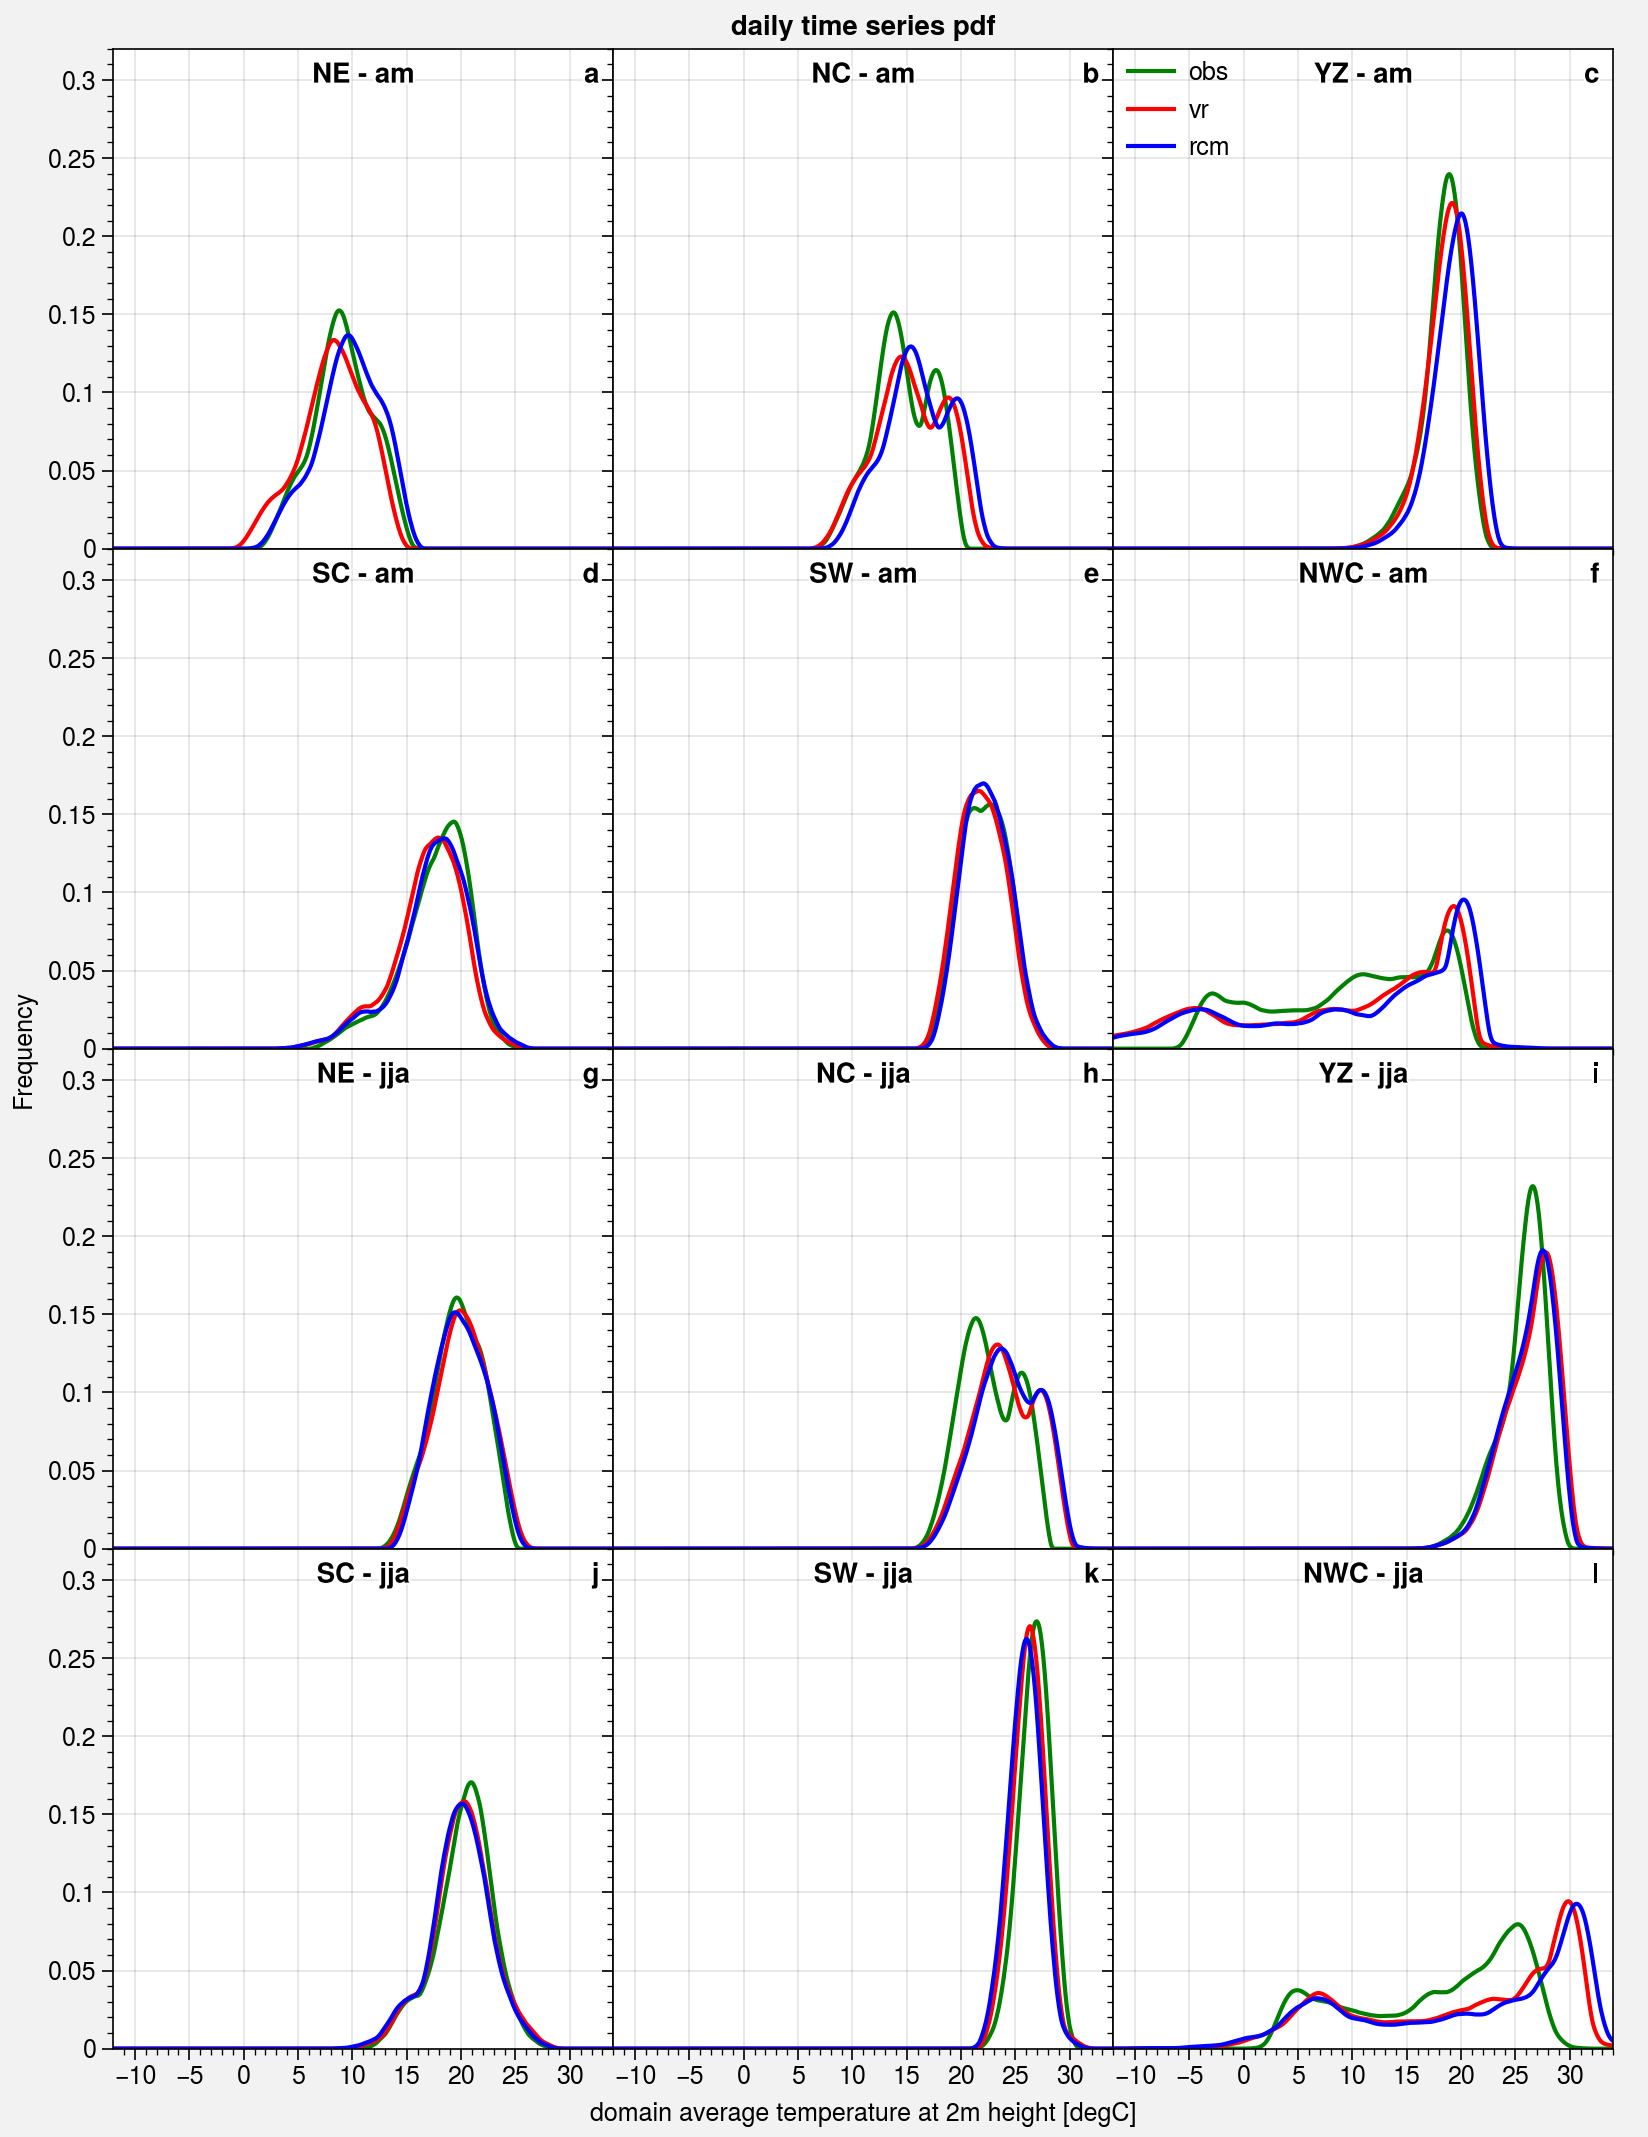

In [18]:
fig, axs = pplt.subplots(ncols = 3, nrows = 4, wspace=0, hspace=0, spanx=True, spany=True, share=3)
# wspace hspace设置宽度， span share共享坐标轴
axs_index = 0
# partial_list = ["NE", "NC", "YZ", "SW"]
# season_list  = [4,5,6,7,8]
season_list  = ['am', 'jja']

for iseason in season_list:
    for iregion in partial_list:
        obs_plot = axs[axs_index].plot(var_bins[iregion]['obs'][iseason], var_kernel[iregion]['obs'][iseason], color='g',label='obs')
        vr_plot  = axs[axs_index].plot(var_bins[iregion]['vr'][iseason], var_kernel[iregion]['vr'][iseason], color='r',label='vr')
        rcm_plot = axs[axs_index].plot(var_bins[iregion]['rcm'][iseason], var_kernel[iregion]['rcm'][iseason], color='b',label='rcm')

        # 设置title
        axs[axs_index].format(title = f'{iregion} - {str(iseason)}' ,titleweight='bold',titleloc='uc',\
            ylabel = "Frequency",xlabel = "domain average temperature at 2m height [degC]")
        # 添加百分号标签，单独设置ticks（把小数转化成百分数）
        # axs[axs_index].set_yticklabels(['{:.1f}%'.format(x*100) for x in axs[axs_index].get_yticks()]) 
        axs_index = axs_index + 1

axs.format(
abc = True,
abcloc="ur",
ylim = (0,0.32),
xlim = (-12,34),
xlocator = 5. ,
xtickminor = True,
xminorlocator = 1. ,
suptitle = "daily time series pdf",
# ylabel = "Frequency",
# xlabel = "domain average precipitation (mm)"
)

axs[2].legend([obs_plot,vr_plot,rcm_plot], loc='ul', ncols=1, frame=False)
# axs[7].format(ylim = (0,0.31))
# saving figs
# plt.savefig("./output_pic/t2m_pdf_5months.png", dpi = 600, facecolor = "white")
plt.savefig("./output_pic/t2m_pdf_2seasons_space.png", dpi = 600, facecolor = "white")